In [ ]:
import os

# Limit TensorFlow to a single thread
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import time

import subprocess
import psutil

In [6]:
# Optional: enforce one-thread execution via config (redundant but safe)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [8]:
start_time = time.time()

In [9]:
# Load data
df = pd.read_csv('/kaggle/input/pdc-dataset/pdc_dataset_with_target.csv')

# Check and remove duplicates
df = df.drop_duplicates()


In [10]:
df.isnull().sum()
df = df.dropna()
df.isnull().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
target       0
dtype: int64

In [11]:
# Column definitions
numerical_cols = ['feature_1', 'feature_2', 'feature_4', 'feature_6','feature_7']
categorical_cols = ['feature_3', 'feature_5']

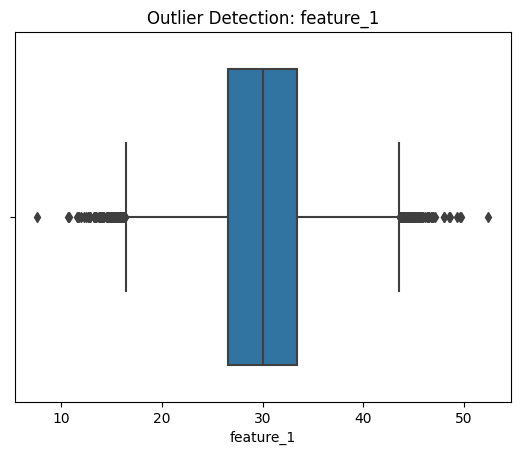

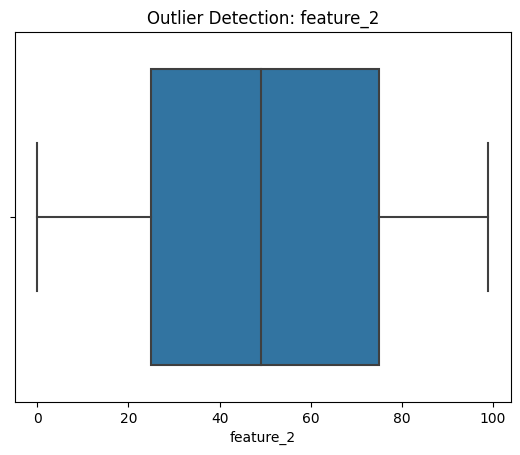

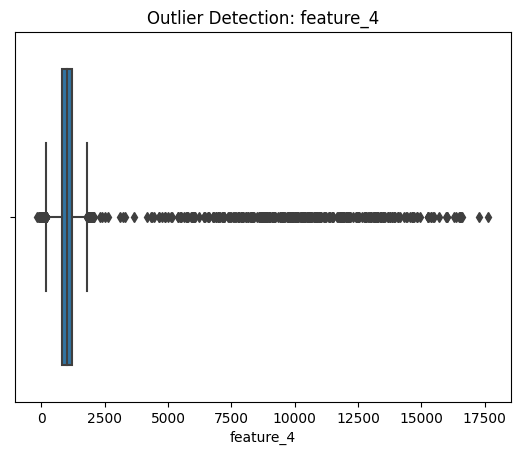

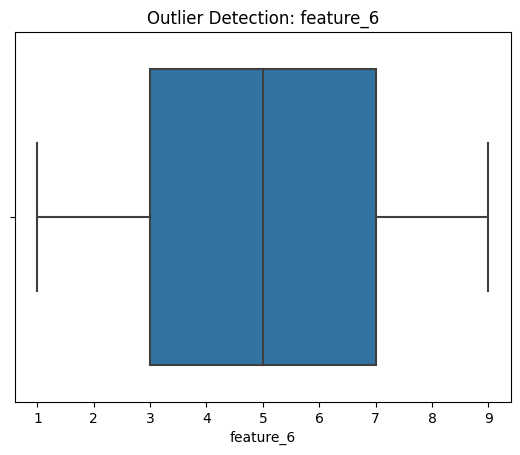

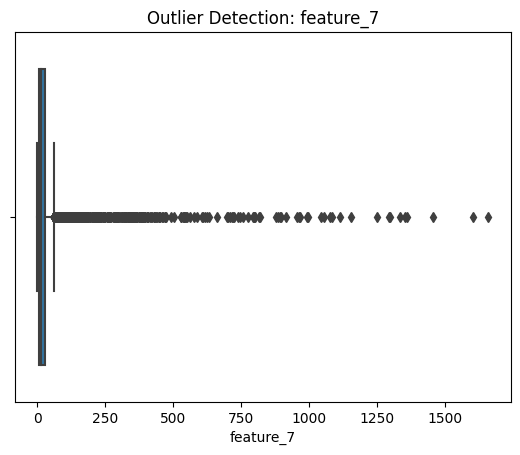

In [12]:
for feature in numerical_cols:
    plt.figure()
    sns.boxplot(x=df[feature])
    plt.title(f'Outlier Detection: {feature}')
    plt.xlabel(feature)
    plt.show()

In [13]:
# Remove outliers using IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

In [14]:
# Convert nulls
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [15]:
# Split data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Normalize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 0.90 seconds


In [17]:
# To store logs
cpu_log, mem_log, gpu_log = [], [], []
# Custom callback to log resource usage
class ResourceLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # CPU and RAM
        cpu = psutil.cpu_percent()
        mem = psutil.virtual_memory().percent

        # GPU: get memory usage from nvidia-smi
        try:
            output = subprocess.check_output(
                ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used',
                 '--format=csv,noheader,nounits'])
            gpu_util, gpu_mem = map(int, output.decode().strip().split(', '))
        except Exception as e:
            gpu_util, gpu_mem = 0, 0  # fallback if no GPU

        cpu_log.append(cpu)
        mem_log.append(mem)
        gpu_log.append(gpu_mem)

        print(f"[Epoch {epoch+1}] CPU: {cpu}%, RAM: {mem}%, GPU Memory Used: {gpu_mem} MB")



# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[ResourceLogger()])

# Evaluate
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/100
584/604 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5968 - auc: 0.5007 - loss: 0.6789[Epoch 1] CPU: 5.4%, RAM: 4.9%, GPU Memory Used: 0 MB
604/604 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5970 - auc: 0.5006 - loss: 0.6788 - val_accuracy: 0.5931 - val_auc: 0.4926 - val_loss: 0.6770
Epoch 2/100
603/604 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6041 - auc: 0.5044 - loss: 0.6737[Epoch 2] CPU: 30.5%, RAM: 4.9%, GPU Memory Used: 0 MB
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6041 - auc: 0.5044 - loss: 0.6737 - val_accuracy: 0.5931 - val_auc: 0.5029 - val_loss: 0.6767
Epoch 3/100
597/604 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6055 - auc: 0.5068 - loss: 0.6720[Epoch 3] CPU: 31.0%, RAM: 4.9%, GPU Memory Used: 0 MB
604/604 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6054 - auc: 0.5068 - loss: 0.6720 - val_accuracy: 0.5931 - val_auc: 0.4985 - val_loss: 0.6761
Epoch 4/100
601/604 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6037 - auc: 0.5070 - l

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 166.52 seconds


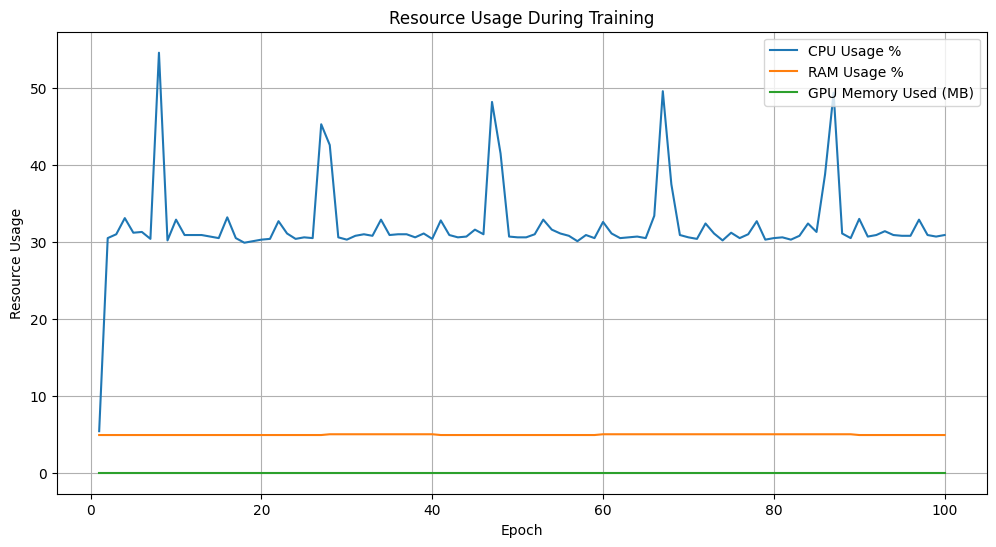

In [19]:
epochs = list(range(1, len(cpu_log)+1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, cpu_log, label='CPU Usage %')
plt.plot(epochs, mem_log, label='RAM Usage %')
plt.plot(epochs, gpu_log, label='GPU Memory Used (MB)')
plt.xlabel("Epoch")
plt.ylabel("Resource Usage")
plt.title("Resource Usage During Training")
plt.legend()
plt.grid(True)
plt.show()
